In [1]:
# =============================================================================
# Program Title: Court Case Preprocessing and Model Training (BART)
# Programmers: Miguel Tolentino
# Date Written: September 29, 2024
# Date Revised: October 17, 2024
#
# Purpose:
#     This program is designed to preprocess legal court case data for machine
#     learning purposes using the BART model. It handles tasks such as paragraph
#     segmentation, data cleaning, tokenization, label balancing, and preparing
#     the data for model training. Additionally, it configures the BART model and
#     trains it using the preprocessed data.
#
#     The goal is to automate the preprocessing and training pipeline for court
#     case analysis, which can later be used for tasks such as legal document
#     classification and summarization.
#
# Where the program fits in the general system design:
#     This program is a key component of a larger legal document processing
#     system. It preprocesses raw court case data to make it suitable for model
#     training, followed by training a machine learning model (BART) to classify
#     legal texts. The outputs from this program are used in downstream processes
#     like classification or prediction tasks in the broader legal document
#     analysis system.
#
# Data Structures, Algorithms, and Control:
#     - Data Structures:
#         - **DataFrame (`df_balanced`)**: A pandas DataFrame containing the
#           balanced court case data with labels.
#         - **List (`segment_labels`)**: A list of integer labels representing the
#           segmented categories (e.g., facts, issues, ruling).
#         - **Dictionary (`train_data`, `eval_data`)**: Data structured for use in
#           model training and evaluation.
#     - Algorithms:
#         - **Text Preprocessing**: Includes tokenization, segmentation, and noise
#           removal to prepare data for the BART model.
#         - **Label Balancing**: Downsampling of majority class labels to handle
#           class imbalance.
#         - **BART Configuration**: Configures the BART model and tokenizer for
#           training.
#         - **Model Training**: Uses the preprocessed data to train the BART model.
#     - Control:
#         - The program follows a sequential execution flow: data preprocessing,
#           BART configuration, data preparation, and model training. Error handling
#           ensures smooth execution for preprocessing steps, but model configuration
#           and training steps assume the data is properly preprocessed and balanced.
# =============================================================================

In [2]:
from Custom_Modules.Preprocess import *
from Custom_Modules.modelling import *
from Custom_Modules.ModelConfiguration import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mdfl0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Preprocessing

In [3]:
# Instantiate the preprocessing class
preprocessor = preprocess('csv_files/all1k.csv', 'csv_files/short_csv_headings_label.csv')

# Remove tokens and characters that are not helpful for the model while doing Paragraph Segmentation
preprocessor.paragraph_segmentation()

# Remove data that doesnt give that much meaning
preprocessor.remove_noisy_data()

# Tokenize the text, storing useful tokens and sentences
preprocessor.tokenize()

# Balance the labels by downsampling the majority classes
preprocessor.balance_labels()

# Outputs a csv file (labels: "facts": 0, "issues": 1, "ruling": 2)
preprocessor.output_csv_file('csv_files/full_court_cases_preprocessed.csv') # add a file name like 'data.csv'

Removing Unnecesary Characters Completed
Paragraph Segmentation Completed
Removing Noisy Data Completed
Tokenization Completed
label
0    64749
1    15935
2     4178
Name: count, dtype: int64
label
1    8000
0    8000
2    8000
Name: count, dtype: int64
Data Balancing Completed


### Run this line of code if you already have a prepared csv files with 2 columns

In [4]:
import pandas as pd
added_issues_df = pd.read_csv("csv_files/new_issues_preprocessed.csv")
added_issues_df = added_issues_df[['sentence','label']]
added_issues_df.rename(columns={'sentence': 'text', 'label':'labels'}, inplace=True, errors='raise')

In [5]:
all_df = pd.read_csv("csv_files/all_preprocessed_data.csv")
all_df = all_df[['sentence','label']]
all_df.rename(columns={'sentence': 'text', 'label':'labels'}, inplace=True, errors='raise')
all_df.dropna(subset=['labels'], inplace=True)
all_df['labels'] = all_df['labels'].astype(int)
all_df = pd.concat([added_issues_df, all_df], axis=0, ignore_index=True)

In [6]:
all_df['labels'].value_counts()

labels
0    63989
1    15881
2     5424
Name: count, dtype: int64

In [7]:
# Separate the DataFrame by label
df_facts = all_df[all_df["labels"] == 1]
df_issues = all_df[all_df["labels"] == 2]
df_rulings = all_df[all_df["labels"] == 0]

# Downsample labels 0 and 1 to 8000 samples each
df_facts_downsampled = resample(
    df_facts, replace=False, n_samples=10000, random_state=42
)
df_rulings_downsampled = resample(
    df_rulings, replace=False, n_samples=10000, random_state=42
)

# Upsample label 2 to 8000 samples if needed
df_issues_upsampled = resample(
    df_issues, replace=True, n_samples=10000, random_state=42
)

# Combine the balanced datasets
df_balanced = pd.concat(
    [df_facts_downsampled, df_issues_upsampled, df_rulings_downsampled]
)

# Shuffle the dataset to ensure randomness
df_balanced = df_balanced.sample(
    frac=1, random_state=42
).reset_index(drop=True)
df_balanced["labels"].value_counts()

labels
1    10000
0    10000
2    10000
Name: count, dtype: int64

# BART Model Configuration

In [8]:
# Instantiate the model configuration class
configurer = model_configure()

# Configure Model and add unknown tokens to the vocabulary of the tokenizer.
configurer.set_model_configuration(preprocessor.sentences_tokens)

Model Configuration Completed


In [9]:
# Return the tokenizer, and model
BART_model, BART_tokenizer= configurer.return_model_tokenizer()

# Prepare the final format of the data for the BART model
preprocessor.prepare_BART_data(BART_tokenizer, df_balanced)

# Return the preprocessed data for training
train_data, eval_data = preprocessor.return_data()

Dataframe shape: (30000, 2)


Map:   0%|          | 0/27000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

# Training of the BART Model

#### Run this line of code if you will retrain model on new data

In [ ]:
from transformers import BartTokenizer, BartForSequenceClassification, BartConfig

# Setup labels
id2label = {0: "rulings", 1: "facts", 2: "issues"}
label2id = {"rulings": 0, "facts": 1, "issues": 2}

# Load tokenizer and model from local directory
BART_tokenizer = BartTokenizer.from_pretrained("my_awesome_model/75")
BART_model = BartForSequenceClassification.from_pretrained(
    "my_awesome_model/75", 
    num_labels=3, 
    id2label=id2label, 
    label2id=label2id,
    problem_type="single_label_classification",
    ignore_mismatched_sizes=True
)

#### Actual training of the model

In [13]:
modeller = Modelling(train_data, eval_data, BART_tokenizer, BART_model)
modeller.train_model()

Step,Training Loss,Validation Loss
500,0.718200,0.651610
1000,0.621600,0.658609
1500,0.536800,0.536202


setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 3000) + inhomogeneous part.
setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 3000) + inhomogeneous part.
setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 3000) + inhomogeneous part.


There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight'].


Overall Accuracy: 0.7787
Overall F1 Score: 0.7775
Overall Recall: 0.7787 

Ruling Accuracy: 0.7355
Ruling F1 Score: 0.8476
Ruling Recall: 0.7355

Facts Accuracy: 0.7230
Facts F1 Score: 0.8392
Facts Recall: 0.7230

Issues Accuracy: 0.8756
Issues F1 Score: 0.9337
Issues Recall: 0.8756



C:\Users\mdfl0\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mdfl0\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mdfl0\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


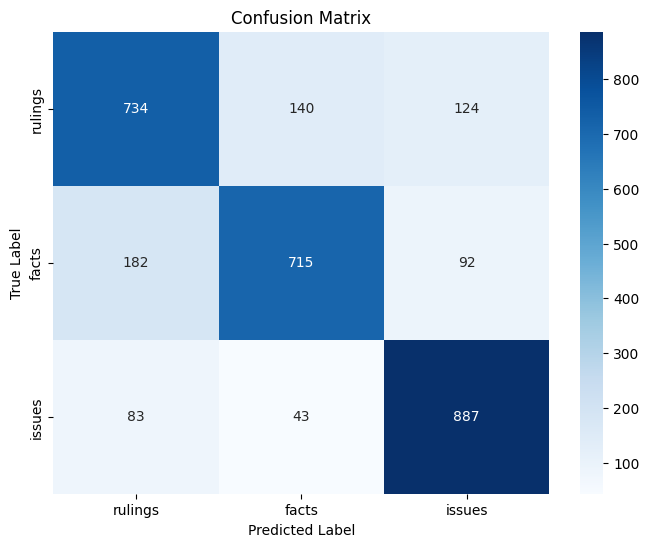

In [14]:
# Show Model Accuracy
modeller.calc_accuracy()

# End of main